# Reconocimiento de emociones

En este archivo se presentarán diversas alternativas para el reconocimiento y análisis de emociones en Hilos de diferente largo.

Para comodidad del lector primero se analizará solo un tweet, luego de presentar el método de análisis se procederá a trabajar todo el dataset.

## Importación de liberias y apertura de archivos

In [1]:
import os
import random
import pandas as pd
import pymongo
from twython import Twython
import time

In [2]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Span

output_notebook()

Loading BokehJS ...

In [3]:
from emotion_predictor import EmotionPredictor

Using Theano backend.


In [4]:
#conexion mongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["twitter-memoria"]
coleccion_completa = mydb["nuevos_tweets"]
bd_hilos = mydb["nuevos_hilos"]

#obtener llaves Twitter
llaves_bd = mydb["llaves"]
llaves = llaves_bd.find_one()

APP_KEY = llaves["API_KEY"]
ACCESS_TOKEN  = llaves["ACCESS_TOKEN_T"]
twitter       = Twython(APP_KEY, access_token=ACCESS_TOKEN)


## Threads como diccionario y como arreglo de string

Se tienen dos formatos para trabajar los datos. El primero es como un diccionario de threads, el cual la clave es el numero de thread y el valor es un arreglo de strings con todos los tweets del thread. La otra es un arreglo de strings, los cuales son todos los tweets unidos en orden separados con un \n

In [5]:
tweets = coleccion_completa.find({})
hilos = bd_hilos.find({})

threads1 = {}
kthreads1 = {}

all_tweets_all = []

all_hilos = {}
for hilo in hilos:
    all_tweets = []
    n_hilo = hilo["hilo"]
    tweets = coleccion_completa.find({"hilo":n_hilo})
    for tweet in tweets:
        tweet_aux = {}
        tweet_aux["hilo"] = n_hilo
        tweet_aux["posicion"] = tweet["pos_hilo"]
        tweet_aux["texto"] = tweet["text"]
        all_tweets_all.append(tweet_aux["texto"])
        all_tweets.append(tweet_aux)    
    all_tweets_sorted = sorted(all_tweets, key = lambda i: i['posicion'])
    nombre = "hilo "+str(n_hilo)
    all_hilos[nombre] = all_tweets_sorted

string = '\n'
for hilo in all_hilos:
    tweets = all_hilos[hilo]
    lista_tweets = []
    for tweet in tweets:
        lista_tweets.append(tweet["texto"])
    threads1[hilo] = lista_tweets
    kthreads1[hilo] = string.join(lista_tweets)
    
Tthreads1 = list(kthreads1.values())

In [6]:
threads1["hilo 1"]

['What a weird coincidence that a group of accounts, starting with Ali, decided to tweet the exact same thing (verbatim) about Kamala Harris within minutes of each other tonight. #DemDebate2 https://t.co/2lxFSJTd77',
 'Watch for this narrative about Kamala Harris to get folded into the astroturfed #BLEXIT movement. That’s where this is headed. \n\nhttps://t.co/JeAmW3k21N',
 'Efforts to attack Kamala Harris’ race have been around for a while, but a huge volume of tweets pushing this manufactured narrative appeared tonight right after Kamala pointed out that she was the only Black woman on stage. #DemDebate2 \n\nhttps://t.co/5IErRicAti']

In [7]:
kthreads1

{'hilo 0': 'NEW: Former president Jimmy Carter says a full investigation “would show that Trump didn’t actually win the election in 2016….He was put into office because the Russians interfered.” Does that mean he’s an illegitimate president? “Based on what I said, which I can’t retract.” https://t.co/Y3UFUBIIDy\nAt @CarterCenter conference on human rights moderated by historian Jon Meacham, former president Jimmy Carter says “every day we send a terrible signal” with border policy, “a disgrace to the United States, and I hope it will soon be ended. Maybe not until the 2020 election.”\nFormer Vice President Walter Mondale on President Trump: “He’s got something deep in him that is detestable.” Cites “his rhetoric, his harshness, his divisiveness,” then adds: “Doctors tell me they think they recognize symptoms of psychological problems.” At @CarterCenter panel',
 'hilo 1': 'What a weird coincidence that a group of accounts, starting with Ali, decided to tweet the exact same thing (verbat

In [8]:
Tthreads1

['NEW: Former president Jimmy Carter says a full investigation “would show that Trump didn’t actually win the election in 2016….He was put into office because the Russians interfered.” Does that mean he’s an illegitimate president? “Based on what I said, which I can’t retract.” https://t.co/Y3UFUBIIDy\nAt @CarterCenter conference on human rights moderated by historian Jon Meacham, former president Jimmy Carter says “every day we send a terrible signal” with border policy, “a disgrace to the United States, and I hope it will soon be ended. Maybe not until the 2020 election.”\nFormer Vice President Walter Mondale on President Trump: “He’s got something deep in him that is detestable.” Cites “his rhetoric, his harshness, his divisiveness,” then adds: “Doctors tell me they think they recognize symptoms of psychological problems.” At @CarterCenter panel',
 'What a weird coincidence that a group of accounts, starting with Ali, decided to tweet the exact same thing (verbatim) about Kamala Har

In [9]:
df_unidos1 = pd.DataFrame.from_dict(kthreads1, orient='index', columns=['Tweet'])

df_unidos1.index.name = "Hilo"
df_unidos1.reset_index(inplace=True)

df_unidos1.head()

,Hilo,Tweet
0,hilo 0,NEW: Former president Jimmy Carter says a full...
1,hilo 1,What a weird coincidence that a group of accou...
2,hilo 2,In light of today's news from the 4th Cir. a r...
3,hilo 3,Everything we think of as futuristic is really...
4,hilo 4,Hatch dismisses allegations of Trump crimes ov...


## Detección de emociones.

Se importa el modelo a utilizar para la detección de emociones. Se trabajará con las emociones definidas por Ekman.

Se extraerán dos emociones por hilo, esto para posibles futuros análisis.

Existen dos alternativas para el output las emociones. La primera es a través de la predicción directa de la emoción, la cual entrega una tabla con la emoción principal de cada documento estudiado. La segunda es a través de una matriz de probabilidades, en la cual las columnas son las emociones y las filas los documentos a analizar. Cada valor de la matríz es la probabilidad de que el documento sea asociado a esa emoción.

In [7]:
ekman = EmotionPredictor(classification='ekman', setting='mc')

In [8]:
tweets = all_tweets_all
matriz = ekman.predict_probabilities(tweets)
tabla = ekman.predict_classes(tweets)

In [13]:
matriz

,Tweet,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,Former Vice President Walter Mondale on Presid...,0.605305,0.004659,0.112803,0.089558,0.025948,0.161728
1,At @CarterCenter conference on human rights mo...,0.127563,0.007504,0.152928,0.620695,0.074487,0.016823
2,NEW: Former president Jimmy Carter says a full...,0.005750,0.000997,0.039262,0.909876,0.016915,0.027200
3,Efforts to attack Kamala Harris’ race have bee...,0.010020,0.003199,0.232621,0.689843,0.025813,0.038504
4,Watch for this narrative about Kamala Harris t...,0.062258,0.037931,0.360974,0.278310,0.124603,0.135923
5,What a weird coincidence that a group of accou...,0.001081,0.000137,0.032268,0.963001,0.000245,0.003268
6,Why aren't more right-side journos and comment...,0.002937,0.000092,0.944420,0.035176,0.016465,0.000910
7,"The details are in that thread, but the bottom...",0.099979,0.005683,0.045653,0.527511,0.186441,0.134732
8,In light of today's news from the 4th Cir. a r...,0.275701,0.367616,0.192948,0.090578,0.033217,0.039940
9,"This is why, and this is no judgement as I lov...",0.010047,0.150258,0.113828,0.081807,0.339337,0.304723


In [14]:
matriz.describe()

,Anger,Disgust,Fear,Joy,Sadness,Surprise
count,5916.000000,5.916000e+03,5916.000000,5916.000000,5916.000000,5916.000000
mean,0.070499,5.218016e-02,0.261597,0.430774,0.063744,0.121206
std,0.109076,1.114037e-01,0.240651,0.306052,0.107990,0.176856
min,0.000001,3.517050e-08,0.000053,0.000022,0.000003,0.000003
25%,0.011029,2.550333e-03,0.069857,0.151674,0.006593,0.011670
50%,0.031306,1.159216e-02,0.185777,0.389225,0.023128,0.044711
75%,0.080309,4.554336e-02,0.389760,0.694599,0.070960,0.152437
max,0.995480,9.848391e-01,0.998699,0.999858,0.940173,0.999005


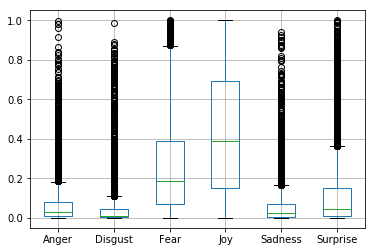

In [15]:
matriz.boxplot(column = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise"])

In [19]:

grafico = figure(plot_width=700, 
           plot_height=350, 
           title='Probabilidad de cada emoción por tweet', 
           background_fill_color="#f2f3f7", 
           y_axis_label='probabilidad', 
           x_axis_label='Tweets along the thread')

grafico.line(list(range(1,5917)), matriz['Anger'].values,line_color='#cd2626', legend='Enojo')
grafico.line(list(range(1,5917)), matriz['Disgust'].values, line_color='#64bd40', legend='Disgusto')
grafico.line(list(range(1,5917)), matriz['Fear'].values, line_color='#cbbeb5', legend='Miedo')
grafico.line(list(range(1,5917)), matriz['Joy'].values, line_color='#ffe700', legend='Alegria')
grafico.line(list(range(1,5917)), matriz['Sadness'].values, line_color='#7cb890', legend='Pena')
grafico.line(list(range(1,5917)), matriz['Surprise'].values, line_color='#ff00db', legend='Sorpresa')

show(grafico)

In [17]:
tabla

,Tweet,Emotion
0,Former Vice President Walter Mondale on Presid...,Anger
1,At @CarterCenter conference on human rights mo...,Joy
2,NEW: Former president Jimmy Carter says a full...,Joy
3,Efforts to attack Kamala Harris’ race have bee...,Joy
4,Watch for this narrative about Kamala Harris t...,Fear
5,What a weird coincidence that a group of accou...,Joy
6,Why aren't more right-side journos and comment...,Fear
7,"The details are in that thread, but the bottom...",Joy
8,In light of today's news from the 4th Cir. a r...,Disgust
9,"This is why, and this is no judgement as I lov...",Sadness


In [18]:
tabla.describe()

,Tweet,Emotion
count,5916,5916
unique,5916,6
top,17/n Results? Large companies picking India a...,Joy
freq,1,3032


## Análisis de emociones según la matriz de probabilidades.

Se poseen varias alternativas para obtener la emoción del thread a través de la matriz, los cuales serán descritos a continuación:

In [20]:
matriz_valores = matriz.drop(columns ="Tweet")
matriz_valores

,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,0.605305,0.004659,0.112803,0.089558,0.025948,0.161728
1,0.127563,0.007504,0.152928,0.620695,0.074487,0.016823
2,0.005750,0.000997,0.039262,0.909876,0.016915,0.027200
3,0.010020,0.003199,0.232621,0.689843,0.025813,0.038504
4,0.062258,0.037931,0.360974,0.278310,0.124603,0.135923
5,0.001081,0.000137,0.032268,0.963001,0.000245,0.003268
6,0.002937,0.000092,0.944420,0.035176,0.016465,0.000910
7,0.099979,0.005683,0.045653,0.527511,0.186441,0.134732
8,0.275701,0.367616,0.192948,0.090578,0.033217,0.039940
9,0.010047,0.150258,0.113828,0.081807,0.339337,0.304723


### Emoción media

Se definió como emoción media a la columna que posea el promedio más alto. 

In [21]:
matriz_media = matriz_valores.mean().to_frame().transpose()
matriz_media

,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,0.070499,0.05218,0.261597,0.430774,0.063744,0.121206


In [22]:
matriz_media.sort_values(by = 0, axis = 1, ascending=False)

,Joy,Fear,Surprise,Anger,Sadness,Disgust
0,0.430774,0.261597,0.121206,0.070499,0.063744,0.05218


In [23]:
matriz_emociones_media_max = list(matriz_media.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
matriz_emociones_media_max

['Joy', 'Fear']

### Emoción más intensa

Se definió como emoción más intensa a la columna que posea el valor máximo más alto de todos.

In [24]:
matriz_emocion = matriz_valores.max().to_frame().transpose().sort_values(by = 0, axis = 1, ascending=False)
matriz_emocion

,Joy,Surprise,Fear,Anger,Disgust,Sadness
0,0.999858,0.999005,0.998699,0.99548,0.984839,0.940173


In [25]:
matriz_emociones_max = list(matriz_emocion.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
matriz_emociones_max

['Joy', 'Surprise']

## Análisis de emociones según la tabla de emociones.

Para analizar las emociones según la tabla es posible considerar la frecuencia en la que aparecen las emociones.

### Emoción Moda

Se definió como emoción moda como la emoción que presenta la mayor frecuencia de aparición

In [26]:
tabla.Emotion.value_counts().to_frame().transpose()

,Joy,Fear,Surprise,Anger,Sadness,Disgust
Emotion,3032,1577,640,233,223,211


In [27]:
tabla_emociones_moda = list(tabla.Emotion.value_counts().to_frame().transpose().iloc[:,0:2])
tabla_emociones_moda

['Joy', 'Fear']

# Estudio de threads como un solo documento

Para estudiar los threads como un sólo documento, se unieron los tweets y luego se ingresó el dataset completo como una colección de documentos. cada fila es un thread y cada columna es la probabilidad de una emoción específica. En este caso solo se posee una forma de analizar las emociones.

### Emoción Hilo

Al existir sólo un arreglo de probabilidades para cada thread, la emoción con mayor probabilidad y la emoción en la tabla es la misma, por lo que de este caso sólo se pueden obtener las primeras 2 emociones más probables para cada thread.

In [27]:
Ttweets = Tthreads1
Tmatriz = ekman.predict_probabilities(Ttweets).drop(columns = "Tweet")

for index, row in Tmatriz.iterrows():
    Tmatriz_emocion = row.to_frame().transpose().sort_values(by = index, axis = 1, ascending=False)
    Tmatriz_emocion_max = list(Tmatriz_emocion.iloc[:,0:2])
    print(Tmatriz_emocion_max)


['Anger', 'Surprise']
['Joy', 'Fear']
['Fear', 'Joy']
['Sadness', 'Surprise']
['Joy', 'Surprise']
['Fear', 'Disgust']
['Fear', 'Sadness']
['Joy', 'Fear']
['Joy', 'Fear']
['Surprise', 'Fear']
['Joy', 'Fear']
['Joy', 'Surprise']
['Fear', 'Joy']
['Joy', 'Surprise']
['Surprise', 'Sadness']
['Fear', 'Surprise']
['Sadness', 'Joy']
['Joy', 'Surprise']
['Joy', 'Fear']
['Joy', 'Anger']
['Fear', 'Surprise']
['Fear', 'Joy']
['Joy', 'Fear']
['Fear', 'Joy']
['Joy', 'Anger']
['Fear', 'Joy']
['Fear', 'Joy']
['Joy', 'Fear']
['Joy', 'Fear']
['Joy', 'Fear']
['Fear', 'Joy']
['Surprise', 'Sadness']
['Anger', 'Joy']
['Joy', 'Fear']
['Joy', 'Fear']
['Anger', 'Sadness']
['Sadness', 'Joy']
['Joy', 'Anger']
['Joy', 'Anger']
['Joy', 'Fear']
['Joy', 'Surprise']
['Joy', 'Fear']
['Joy', 'Fear']
['Surprise', 'Joy']
['Fear', 'Joy']
['Fear', 'Joy']
['Joy', 'Fear']
['Joy', 'Fear']
['Fear', 'Joy']
['Fear', 'Joy']
['Anger', 'Sadness']
['Joy', 'Fear']
['Joy', 'Fear']
['Surprise', 'Joy']
['Fear', 'Joy']
['Joy', 'Fear']
['

# Estudio del dataset completo por tweets separados.

Luego de presentar todos los métodos definidos para obtención la emoción para cada thread, se procede a calcularlos.

## CSV five_ten

In [28]:
threads_estudio = threads1

tweets_analisis = []

emocion_media = []
emocion_presente = []
emocion_moda = []

etiquetas = ["Thread", "1ra Emocion", "2da Emocion"]


for hilo in threads_estudio:
    print(hilo)
    #Conseguir Emociones
    tweets_analisis = threads_estudio[hilo]
    matriz_hilo_analizado = ekman.predict_probabilities(tweets_analisis).drop(columns ="Tweet")
    tabla_hilo_analizado = ekman.predict_classes(tweets_analisis)
    
    #Emocion media
    matriz_media_analisis = matriz_hilo_analizado.mean().to_frame().transpose()
    matriz_emociones_media_max_analisis = list(matriz_media_analisis.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
    matriz_emociones_media_max_analisis.insert(0, hilo)
    print(matriz_emociones_media_max_analisis)
    
    #Emocion mas intensa
    matriz_emocion_analisis = matriz_hilo_analizado.max().to_frame().transpose().sort_values(by = 0, axis = 1, ascending=False)
    matriz_emociones_max_analisis = list(matriz_emocion_analisis.sort_values(by = 0, axis = 1, ascending=False).iloc[:,0:2])
    matriz_emociones_max_analisis.insert(0, hilo)
    print(matriz_emociones_max_analisis)
    
    #Emocion moda
    tabla_emociones_moda_analisis = list(tabla_hilo_analizado.Emotion.value_counts().to_frame().transpose().iloc[:,0:2])
    tabla_emociones_moda_analisis.insert(0, hilo)
    print(tabla_emociones_moda_analisis)
    
    
    #Agregar a lista de listas
    
    emocion_media.append(matriz_emociones_media_max_analisis)
    emocion_presente.append(matriz_emociones_max_analisis)
    emocion_moda.append(tabla_emociones_moda_analisis)

# Creacion de dataframes    
dataframe_emocion_media = pd.DataFrame.from_records(emocion_media, columns = etiquetas)
dataframe_emocion_presente = pd.DataFrame.from_records(emocion_presente, columns = etiquetas)
dataframe_emocion_moda = pd.DataFrame.from_records(emocion_moda, columns = etiquetas)

# Guardado de dataframes

dataframe_emocion_media_1 = dataframe_emocion_media
dataframe_emocion_presente_1 = dataframe_emocion_presente
dataframe_emocion_moda_1 = dataframe_emocion_moda

hilo 0
['hilo 0', 'Joy', 'Anger']
['hilo 0', 'Joy', 'Anger']
['hilo 0', 'Joy', 'Anger']
hilo 1
['hilo 1', 'Joy', 'Fear']
['hilo 1', 'Joy', 'Fear']
['hilo 1', 'Joy', 'Fear']
hilo 2
['hilo 2', 'Fear', 'Joy']
['hilo 2', 'Fear', 'Joy']
['hilo 2', 'Fear', 'Joy']
hilo 3
['hilo 3', 'Joy', 'Fear']
['hilo 3', 'Joy', 'Fear']
['hilo 3', 'Fear', 'Joy']
hilo 4
['hilo 4', 'Joy', 'Surprise']
['hilo 4', 'Surprise', 'Joy']
['hilo 4', 'Joy', 'Surprise']
hilo 5
['hilo 5', 'Joy', 'Fear']
['hilo 5', 'Joy', 'Fear']
['hilo 5', 'Joy', 'Surprise']
hilo 6
['hilo 6', 'Fear', 'Disgust']
['hilo 6', 'Fear', 'Disgust']
['hilo 6', 'Fear', 'Disgust']
hilo 7
['hilo 7', 'Joy', 'Fear']
['hilo 7', 'Joy', 'Fear']
['hilo 7', 'Joy', 'Fear']
hilo 8
['hilo 8', 'Joy', 'Fear']
['hilo 8', 'Joy', 'Fear']
['hilo 8', 'Joy', 'Fear']
hilo 9
['hilo 9', 'Surprise', 'Joy']
['hilo 9', 'Joy', 'Surprise']
['hilo 9', 'Surprise', 'Joy']
hilo 10
['hilo 10', 'Joy', 'Fear']
['hilo 10', 'Joy', 'Fear']
['hilo 10', 'Joy', 'Fear']
hilo 11
['hilo 11'

['hilo 90', 'Joy', 'Fear']
['hilo 90', 'Fear', 'Joy']
['hilo 90', 'Joy', 'Fear']
hilo 91
['hilo 91', 'Joy', 'Fear']
['hilo 91', 'Joy', 'Fear']
['hilo 91', 'Joy', 'Fear']
hilo 92
['hilo 92', 'Joy', 'Sadness']
['hilo 92', 'Joy', 'Sadness']
['hilo 92', 'Sadness', 'Joy']
hilo 93
['hilo 93', 'Joy', 'Fear']
['hilo 93', 'Fear', 'Joy']
['hilo 93', 'Joy', 'Anger']
hilo 94
['hilo 94', 'Joy', 'Surprise']
['hilo 94', 'Joy', 'Surprise']
['hilo 94', 'Joy', 'Fear']
hilo 95
['hilo 95', 'Joy', 'Fear']
['hilo 95', 'Joy', 'Fear']
['hilo 95', 'Joy', 'Fear']
hilo 96
['hilo 96', 'Joy', 'Fear']
['hilo 96', 'Joy', 'Fear']
['hilo 96', 'Joy', 'Surprise']
hilo 97
['hilo 97', 'Joy', 'Fear']
['hilo 97', 'Joy', 'Fear']
['hilo 97', 'Joy', 'Fear']
hilo 98
['hilo 98', 'Joy', 'Fear']
['hilo 98', 'Joy', 'Fear']
['hilo 98', 'Joy', 'Fear']
hilo 99
['hilo 99', 'Joy', 'Fear']
['hilo 99', 'Fear', 'Joy']
['hilo 99', 'Joy', 'Fear']
hilo 100
['hilo 100', 'Joy', 'Fear']
['hilo 100', 'Joy', 'Sadness']
['hilo 100', 'Joy', 'Fear']


['hilo 176', 'Joy', 'Fear']
['hilo 176', 'Joy', 'Fear']
['hilo 176', 'Joy', 'Fear']
hilo 177
['hilo 177', 'Joy', 'Fear']
['hilo 177', 'Joy', 'Surprise']
['hilo 177', 'Joy', 'Fear']
hilo 178
['hilo 178', 'Joy', 'Fear']
['hilo 178', 'Joy', 'Fear']
['hilo 178', 'Joy', 'Fear']
hilo 179
['hilo 179', 'Fear', 'Joy']
['hilo 179', 'Fear', 'Anger']
['hilo 179', 'Joy', 'Fear']
hilo 180
['hilo 180', 'Joy', 'Fear']
['hilo 180', 'Fear', 'Joy']
['hilo 180', 'Joy', 'Fear']
hilo 181
['hilo 181', 'Joy', 'Surprise']
['hilo 181', 'Joy', 'Surprise']
['hilo 181', 'Joy', 'Surprise']
hilo 182
['hilo 182', 'Joy', 'Fear']
['hilo 182', 'Joy', 'Fear']
['hilo 182', 'Joy', 'Fear']
hilo 183
['hilo 183', 'Surprise', 'Joy']
['hilo 183', 'Surprise', 'Joy']
['hilo 183', 'Surprise', 'Joy']
hilo 184
['hilo 184', 'Fear', 'Joy']
['hilo 184', 'Fear', 'Joy']
['hilo 184', 'Fear', 'Joy']
hilo 185
['hilo 185', 'Fear', 'Joy']
['hilo 185', 'Fear', 'Joy']
['hilo 185', 'Fear', 'Joy']
hilo 186
['hilo 186', 'Joy', 'Fear']
['hilo 186',

['hilo 263', 'Joy', 'Fear']
['hilo 263', 'Joy', 'Fear']
['hilo 263', 'Joy', 'Fear']
hilo 264
['hilo 264', 'Joy', 'Fear']
['hilo 264', 'Joy', 'Fear']
['hilo 264', 'Joy', 'Fear']
hilo 265
['hilo 265', 'Joy', 'Fear']
['hilo 265', 'Joy', 'Fear']
['hilo 265', 'Joy', 'Fear']
hilo 266
['hilo 266', 'Joy', 'Surprise']
['hilo 266', 'Joy', 'Surprise']
['hilo 266', 'Joy', 'Surprise']
hilo 267
['hilo 267', 'Joy', 'Fear']
['hilo 267', 'Joy', 'Fear']
['hilo 267', 'Joy', 'Fear']
hilo 268
['hilo 268', 'Joy', 'Fear']
['hilo 268', 'Joy', 'Fear']
['hilo 268', 'Joy', 'Fear']
hilo 269
['hilo 269', 'Joy', 'Fear']
['hilo 269', 'Joy', 'Fear']
['hilo 269', 'Joy', 'Fear']
hilo 270
['hilo 270', 'Joy', 'Surprise']
['hilo 270', 'Joy', 'Disgust']
['hilo 270', 'Joy', 'Surprise']
hilo 271
['hilo 271', 'Fear', 'Joy']
['hilo 271', 'Fear', 'Sadness']
['hilo 271', 'Fear', 'Joy']
hilo 272
['hilo 272', 'Joy', 'Fear']
['hilo 272', 'Joy', 'Fear']
['hilo 272', 'Joy', 'Fear']
hilo 273
['hilo 273', 'Joy', 'Fear']
['hilo 273', 'J

['hilo 350', 'Joy', 'Fear']
['hilo 350', 'Joy', 'Fear']
['hilo 350', 'Joy', 'Fear']
hilo 351
['hilo 351', 'Joy', 'Fear']
['hilo 351', 'Sadness', 'Joy']
['hilo 351', 'Joy', 'Fear']
hilo 352
['hilo 352', 'Joy', 'Fear']
['hilo 352', 'Joy', 'Fear']
['hilo 352', 'Joy', 'Fear']
hilo 353
['hilo 353', 'Joy', 'Fear']
['hilo 353', 'Joy', 'Fear']
['hilo 353', 'Joy', 'Fear']
hilo 354
['hilo 354', 'Joy', 'Fear']
['hilo 354', 'Joy', 'Anger']
['hilo 354', 'Joy', 'Surprise']
hilo 355
['hilo 355', 'Joy', 'Fear']
['hilo 355', 'Joy', 'Fear']
['hilo 355', 'Joy', 'Fear']
hilo 356
['hilo 356', 'Joy', 'Fear']
['hilo 356', 'Joy', 'Fear']
['hilo 356', 'Joy', 'Fear']
hilo 357
['hilo 357', 'Joy', 'Fear']
['hilo 357', 'Joy', 'Surprise']
['hilo 357', 'Joy', 'Fear']
hilo 358
['hilo 358', 'Joy', 'Fear']
['hilo 358', 'Fear', 'Surprise']
['hilo 358', 'Joy', 'Fear']
hilo 359
['hilo 359', 'Joy', 'Fear']
['hilo 359', 'Joy', 'Surprise']
['hilo 359', 'Joy', 'Surprise']
hilo 360
['hilo 360', 'Joy', 'Fear']
['hilo 360', 'Joy

# Estudio del dataset completo por threads unidos.

## CSV five_ten

In [29]:
Ttweets = Tthreads1
Tmatriz = ekman.predict_probabilities(Ttweets)
Tdf_unidos = df_unidos1

Tmatriz_emocion = []
Tmatriz_emocion_max = []

Temocion_max = []
dataframe_Temocion_max = []

unidos = []
u2 = []

unidos = Tdf_unidos.join(Tmatriz.set_index('Tweet'), on='Tweet')
u2 = unidos.set_index("Hilo").drop(columns = ["Tweet"])

#Sacar dos emociones maximas
for index, row in u2.iterrows():
    Tmatriz_emocion = row.to_frame().transpose().sort_values(by = index, axis = 1, ascending=False)
    Tmatriz_emocion_max = list(Tmatriz_emocion.iloc[:,0:2])
    Tmatriz_emocion_max.insert(0, index)
    print(Tmatriz_emocion_max)
    Temocion_max.append(Tmatriz_emocion_max)

    
#Matriz a dataframe    
dataframe_Temocion_max = pd.DataFrame.from_records(Temocion_max, columns = etiquetas)

#Guardar Dataframe
dataframe_Temocion_max_1 = dataframe_Temocion_max

['hilo 0', 'Anger', 'Surprise']
['hilo 1', 'Joy', 'Fear']
['hilo 2', 'Fear', 'Joy']
['hilo 3', 'Sadness', 'Surprise']
['hilo 4', 'Joy', 'Surprise']
['hilo 5', 'Fear', 'Disgust']
['hilo 6', 'Fear', 'Sadness']
['hilo 7', 'Joy', 'Fear']
['hilo 8', 'Joy', 'Fear']
['hilo 9', 'Surprise', 'Fear']
['hilo 10', 'Joy', 'Fear']
['hilo 11', 'Joy', 'Surprise']
['hilo 12', 'Fear', 'Joy']
['hilo 13', 'Joy', 'Surprise']
['hilo 14', 'Surprise', 'Sadness']
['hilo 15', 'Fear', 'Surprise']
['hilo 16', 'Sadness', 'Joy']
['hilo 17', 'Joy', 'Surprise']
['hilo 18', 'Joy', 'Fear']
['hilo 19', 'Joy', 'Anger']
['hilo 20', 'Fear', 'Surprise']
['hilo 21', 'Fear', 'Joy']
['hilo 22', 'Joy', 'Fear']
['hilo 23', 'Fear', 'Joy']
['hilo 24', 'Joy', 'Anger']
['hilo 25', 'Fear', 'Joy']
['hilo 26', 'Fear', 'Joy']
['hilo 27', 'Joy', 'Fear']
['hilo 28', 'Joy', 'Fear']
['hilo 29', 'Joy', 'Fear']
['hilo 30', 'Fear', 'Joy']
['hilo 31', 'Surprise', 'Sadness']
['hilo 32', 'Anger', 'Joy']
['hilo 33', 'Joy', 'Fear']
['hilo 34', 'Joy'

['hilo 298', 'Joy', 'Surprise']
['hilo 299', 'Joy', 'Fear']
['hilo 300', 'Fear', 'Sadness']
['hilo 301', 'Fear', 'Anger']
['hilo 302', 'Joy', 'Fear']
['hilo 303', 'Joy', 'Anger']
['hilo 304', 'Joy', 'Fear']
['hilo 305', 'Joy', 'Fear']
['hilo 306', 'Joy', 'Fear']
['hilo 307', 'Fear', 'Joy']
['hilo 308', 'Fear', 'Joy']
['hilo 309', 'Fear', 'Joy']
['hilo 310', 'Joy', 'Fear']
['hilo 311', 'Joy', 'Surprise']
['hilo 312', 'Fear', 'Disgust']
['hilo 313', 'Joy', 'Fear']
['hilo 314', 'Anger', 'Fear']
['hilo 315', 'Fear', 'Joy']
['hilo 316', 'Joy', 'Fear']
['hilo 317', 'Anger', 'Sadness']
['hilo 318', 'Fear', 'Disgust']
['hilo 319', 'Joy', 'Anger']
['hilo 320', 'Fear', 'Joy']
['hilo 321', 'Joy', 'Anger']
['hilo 322', 'Disgust', 'Fear']
['hilo 323', 'Joy', 'Fear']
['hilo 324', 'Joy', 'Fear']
['hilo 325', 'Joy', 'Fear']
['hilo 326', 'Joy', 'Fear']
['hilo 327', 'Fear', 'Joy']
['hilo 328', 'Joy', 'Fear']
['hilo 329', 'Joy', 'Fear']
['hilo 330', 'Fear', 'Joy']
['hilo 331', 'Fear', 'Anger']
['hilo 332

In [30]:
dataframe_Temocion_max_1.head()

,Thread,1ra Emocion,2da Emocion
0,hilo 0,Anger,Surprise
1,hilo 1,Joy,Fear
2,hilo 2,Fear,Joy
3,hilo 3,Sadness,Surprise
4,hilo 4,Joy,Surprise


# Analisis de resultados

Luego de obtener las emociones de los threads tanto para los threads por separados, como para los tweets unidos, se procede a comparar los valores obtenidos

## Emociones más presentes en el dataset en la primera emoción según métodos

Se obtendrán la frecuencia de todas las emociones presentes en el dataset, para así comparar la diferencia entre los métodos de clasificación.



## CSV1



### Emoción media

In [31]:
dataframe_emocion_media_1["1ra Emocion"].value_counts().to_frame().transpose()

,Joy,Fear,Surprise
1ra Emocion,324,57,11


### Emoción más intensa

In [32]:
dataframe_emocion_presente_1["1ra Emocion"].value_counts().to_frame().transpose()

,Joy,Fear,Surprise,Disgust,Anger,Sadness
1ra Emocion,279,80,21,6,4,2


### Emoción moda

In [33]:
dataframe_emocion_moda_1["1ra Emocion"].value_counts().to_frame().transpose()

,Joy,Fear,Surprise,Anger,Sadness
1ra Emocion,317,62,9,2,2


### Emoción hilo

In [34]:
dataframe_Temocion_max_1["1ra Emocion"].value_counts().to_frame().transpose()

,Joy,Fear,Surprise,Anger,Sadness,Disgust
1ra Emocion,220,109,20,19,16,8


In [40]:

memedia =   [0,0,57,324,0,11]
meintensa = [4,6,80,279,2,21]
memoda =    [2,0,62,317,2,9]
mehilo =    [19,8,109,220,16,20]

grafico = figure(plot_width=700, 
           plot_height=350, 
           title='Distribución de Emociones por Técnica', 
           background_fill_color="#f2f3f7", 
           y_axis_label='Cantidad', 
           x_axis_label='Emocion')

grafico.line(list(range(1,7)), memedia,line_color='#cd2626', legend='Media')
grafico.line(list(range(1,7)), meintensa, line_color='#64bd40', legend='Intensa')
grafico.line(list(range(1,7)), memoda, line_color='#cbbeb5', legend='Moda')
grafico.line(list(range(1,7)), mehilo, line_color='#ffe700', legend='Hilo')

show(grafico)

In [ ]:
for index, row in dataframe_emocion_media_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_media" : lista_emocion} } )

for index, row in dataframe_emocion_presente_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_presente" : lista_emocion} } )

for index, row in dataframe_emocion_moda_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_moda" : lista_emocion} } )

for index, row in dataframe_Temocion_max_1.iterrows():
    hilo = row["Thread"].split()
    n_hilo = int(hilo[1])
    primera = row["1ra Emocion"]
    segunda = row["2da Emocion"]
    lista_emocion = [primera, segunda]
    actualizar = bd_hilos.update_one({"hilo" : n_hilo}, {"$set" : { "emocion_max" : lista_emocion} } )


In [ ]:
todos_tweets = coleccion_completa.find({})

lista_todos_tweets = [elemento["text"] for elemento in todos_tweets]
todos_tabla = ekman.predict_classes(lista_todos_tweets)

In [ ]:
for index, row in todos_tabla.iterrows():
    texto_tabla = row["Tweet"]
    emocion_tabla = row["Emotion"]
    actualizar = coleccion_completa.update_one({"text": texto_tabla}, {"$set" : {"emocion" : emocion_tabla}})

emociones

In [ ]:
todos_tabla.describe()